<a href="https://colab.research.google.com/github/lsuviz/colab-experiments/blob/main/SIREN_Audio_Encoding_Safe_Crossover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siren Exploration

This is a colab to explore properties of the Siren MLP, proposed in our work [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren).


We will first implement a streamlined version of Siren for fast experimentation. This lacks the code to easily do baseline comparisons - please refer to the main code for that - but will greatly simplify the code!

**Make sure that you have enabled the GPU under Edit -> Notebook Settings!**

We will then reproduce the following results from the paper: 
* [Fitting an image](#section_1)
* [Fitting an audio signal](#section_2)
* [Solving Poisson's equation](#section_3)
* [Initialization scheme & distribution of activations](#activations)
* [Distribution of activations is shift-invariant](#shift_invariance)

We will also explore Siren's [behavior outside of the training range](#out_of_range).

Let's go! First, some imports, and a function to quickly generate coordinate grids.

In [1]:
!nvidia-smi

Fri Feb 26 22:32:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
!pip install librosa
!pip install natsort
!pip install pydub
!pip install soundfile

In [14]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import scipy.io.wavfile as wavfile
import io
from IPython.display import Audio

import os
import csv
import pandas as pd
import pickle
from collections import OrderedDict

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [9]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            print('activation count: ', activation_count)
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                # Commented out because we do not need intermediates
                # activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                # activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1
            

        return activations

And finally, differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.

In [4]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

## Fitting an audio signal
<a id='section_2'></a>

Here, we'll use Siren to parameterize an audio signal - i.e., we seek to parameterize an audio waverform $f(t)$  at time points $t$ by a SIREN $\Phi$.

That is we seek the function $\Phi$ such that:  $\mathcal{L}\int_\Omega \lVert \Phi(t) - f(t) \rVert \mathrm{d}t$  is minimized, in which  $\Omega$  is the domain of the waveform.

For the audio, we'll use the bach sonata:

In [5]:
%cd /content/

/content


Let's build a little dataset that computes coordinates for audio files:

In [11]:
class AudioFile(torch.utils.data.Dataset):
    def __init__(self, filename):
        self.rate, self.data = wavfile.read(filename)
        self.data = self.data.astype(np.float32)
        self.timepoints = get_mgrid(len(self.data), 1)

    def get_num_samples(self):
        return self.timepoints.shape[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        amplitude = self.data
        scale = np.max(np.abs(amplitude))
        amplitude = (amplitude / scale)
        amplitude = torch.Tensor(amplitude).view(-1, 1)
        return self.timepoints, amplitude

In [12]:
!pwd

/content


In [13]:
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def showimage(im, c01=False, bgr=False, axes=None):
    if c01:
        # switch order from c,0,1 -> 0,1,c
        im = im.transpose((1,2,0))
    if im.ndim == 3 and bgr:
        # Change from BGR -> RGB
        im = im[:, :, ::-1]
    if axes is None:
        plt.imshow(im)
    else:
        axes.imshow(im)
    #axis('tight')

def showimagesc(im, c01=False, bgr=False, center=None, axes=None):
    if center is None:
        showimage(norm01(im), c01=c01, bgr=bgr, axes=axes)
    else:
        showimage(norm01c(im, center), c01=c01, bgr=bgr, axes=axes)

def get_float_copy(arr):
    '''Returns a copy of an array, upconverting int types to float'''
    if 'int' in str(arr.dtype):
        return array(arr.copy(), dtype='float')
    else:
        return arr.copy()


def norm01(arr):
    arr = get_float_copy(arr)
    arr -= arr.min()
    arr /= arr.max()
    return arr

In [16]:
# Download two 8s chunks of Joe Pass guitar solo

%mkdir /content/samples/
%cd /content/samples/
!gdown --id 1Jjae2V03x82UNzS_67jclYn3OoYjT4ol
!gdown --id 1Yx2Yyr7F_r71XOBSlDaByjK-UnRrO-Ag
%cd ../

/content/samples
Downloading...
From: https://drive.google.com/uc?id=1Jjae2V03x82UNzS_67jclYn3OoYjT4ol
To: /content/samples/joe1.wav
100% 192k/192k [00:00<00:00, 70.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Yx2Yyr7F_r71XOBSlDaByjK-UnRrO-Ag
To: /content/samples/joe2.wav
100% 192k/192k [00:00<00:00, 72.4MB/s]
/content


In [19]:
# Listen to ground truth (the files downloaded above)

path = os.path.join('/content/samples/', 'joe1.wav')
audio_file = AudioFile(path)

dataloader = DataLoader(audio_file, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)
sample_rate = audio_file.rate

model_input, ground_truth = next(iter(dataloader))

print("Joe Pass Audio 1")
display(Audio(ground_truth.cpu().detach().squeeze().numpy(), rate=sample_rate))

path = os.path.join('/content/samples/', 'joe2.wav')
audio_file = AudioFile(path)

dataloader = DataLoader(audio_file, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)
sample_rate = audio_file.rate

model_input, ground_truth = next(iter(dataloader))

print("Joe Pass Audio 2")
display(Audio(ground_truth.cpu().detach().squeeze().numpy(), rate=sample_rate))

Joe Pass Audio 1


Joe Pass Audio 2


/content/samples/joe1.wav
Step 0, Total loss 0.029198
Step 100, Total loss 0.000275
Step 200, Total loss 0.000200
Step 300, Total loss 0.000131
Step 400, Total loss 0.000103
Step 500, Total loss 0.000099
Step 600, Total loss 0.000079
Step 700, Total loss 0.000072
Step 800, Total loss 0.000065
Step 900, Total loss 0.000089


/content/samples/joe1.wav
activation count:  0
activation count:  1
activation count:  2
activation count:  3
activation count:  4
activation count:  5
activation count:  6
layer name:  input
layer name:  <class '__main__.SineLayer'>_0
layer name:  <class '__main__.SineLayer'>_1
layer name:  <class '__main__.SineLayer'>_2
layer name:  <class '__main__.SineLayer'>_3
layer name:  <class '__main__.SineLayer'>_4
layer name:  <class '__main__.SineLayer'>_5
layer name:  <class 'torch.nn.modules.linear.Linear'>_6
/content/samples/joe1.wav
Step 0, Total loss 0.029861
Step 100, Total loss 0.000268
Step 200, Total loss 0.000233
Step 300, Total loss 0.000502
Step 400, Total loss 0.000442
Step 500, Total loss 0.000089
Step 600, Total loss 0.000087
Step 700, Total loss 0.000070
Step 800, Total loss 0.000079
Step 900, Total loss 0.000059


/content/samples/joe1.wav
activation count:  0
activation count:  1
activation count:  2
activation count:  3
activation count:  4
activation count:  5
activation count:  6
layer name:  input
layer name:  <class '__main__.SineLayer'>_0
layer name:  <class '__main__.SineLayer'>_1
layer name:  <class '__main__.SineLayer'>_2
layer name:  <class '__main__.SineLayer'>_3
layer name:  <class '__main__.SineLayer'>_4
layer name:  <class '__main__.SineLayer'>_5
layer name:  <class 'torch.nn.modules.linear.Linear'>_6
R1_xy shape:  (256, 256)


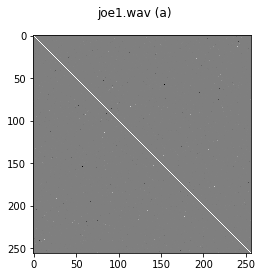

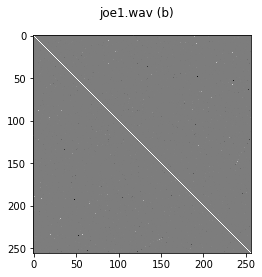

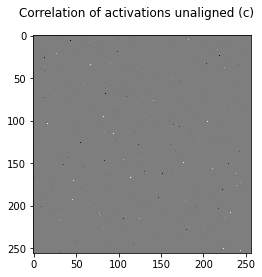

In [21]:
# find out most correlated neurons pair between 2 nets in the same layer

def get_model_input_ground_truth(directory, filename):
  path = os.path.join(directory, filename)
  print(path)

  audio_file = AudioFile(path)

  dataloader = DataLoader(audio_file, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)
  sample_rate = audio_file.rate

  model_input, ground_truth = next(iter(dataloader))

  return model_input, ground_truth, sample_rate

 
def train_SIREN(directory, filename, audio_siren, lr=1e-4, input_range=1, total_steps=2000, steps_till_summary=100):

  model_input, ground_truth, rate = get_model_input_ground_truth(directory, filename)

  audio_siren = pickle.loads(pickle.dumps(audio_siren))
  audio_siren.cuda()

  optim = torch.optim.Adam(lr=lr, params=audio_siren.parameters())

  model_input = model_input * input_range
  model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

  for step in range(total_steps):
      model_output, coords = audio_siren(model_input)    
      loss = F.mse_loss(model_output, ground_truth)
      
      if not step % steps_till_summary:
          print("Step %d, Total loss %0.6f" % (step, loss))

      optim.zero_grad()
      loss.backward()
      optim.step()

  aud = audio_siren(model_input)[0]

  display(Audio(ground_truth.cpu().detach().squeeze().numpy(), rate=rate))
  display(Audio(aud.cpu().detach().squeeze().numpy(), rate=rate))

  return audio_siren
 

def get_activations(directory, filename, audio_siren, layer_name="<class '__main__.SineLayer'>_0"):
  parent = train_SIREN(directory, filename, audio_siren, total_steps=1000)

  model_input, ground_truth, rate = get_model_input_ground_truth(directory, filename)
  model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

  activations = (parent.forward_with_activations(model_input))

  activations_res = []
  i = 0
  for ac in activations:
    print('layer name: ',ac)
    if (ac == 'input'):
      continue
    elif (ac == layer_name):
    

      aa = activations[ac].cpu().detach().squeeze().numpy()

      n = norm01(aa.T)
      R1 = np.corrcoef(n)
      
      activations_res.append(n)

  return (activations_res), parent


# get activation for this layer
layer_name = "<class '__main__.SineLayer'>_0"

# -------- train net 1 ---------------
# instantiate SIREN for first audio
audio_siren_joe1 = Siren(in_features=1, out_features=1, hidden_features=256, 
                              hidden_layers=5, first_omega_0=3000, outermost_linear=True)
audio_siren_joe1.cuda()

directory = '/content/samples/'

filename1 = 'joe1.wav'
activations, audio_siren_joe1 = get_activations(directory, filename1, audio_siren_joe1, layer_name)
activations = activations[0]



# --------- train net 2 ---------------
# reset SIREN for second audio
audio_siren_joe2 = Siren(in_features=1, out_features=1, hidden_features=256, 
                              hidden_layers=5, first_omega_0=3000, outermost_linear=True)
filename2 = 'joe1.wav' #both filenames point to same file. 
activations2, audio_siren_joe2 = get_activations(directory, filename2, audio_siren_joe2, layer_name)
activations2 = activations2[0]


# self-correlation with net1 layer0
R1_x = np.corrcoef(activations)
fig = plt.figure()
fig.suptitle(filename1+' (a) ', fontsize=12)
showimagesc(R1_x)

# self-correlation with net2 layer0
R1_y = np.corrcoef(activations2)
fig = plt.figure()
fig.suptitle(filename2+' (b)', fontsize=12)
showimagesc(R1_y)

# correlation of activations
# take the bottom left quadrant
R1_xy = np.corrcoef(activations, activations2)[:256, 256:]
print('R1_xy shape: ', R1_xy.shape)

fig = plt.figure()
fig.suptitle('Correlation of activations unaligned (c)', fontsize=12)
showimagesc(R1_xy)



[(0, 118, 0.017260511598581062), (1, 208, 0.01037510798328472), (2, 13, 0.013326780756447804), (3, 51, 0.09988246211709675), (4, 82, 0.026867947558303407), (5, 149, 0.02487755091204796), (6, 69, 0.02883559633771), (7, 92, 0.029011579898172084), (8, 65, 0.1727468078609195), (9, 5, 0.010286088754502012), (10, 19, 0.016800122778351807), (11, 176, 0.017428057725598477), (12, 52, 0.010964035377735232), (13, 211, 0.005865380266689405), (14, 183, 0.00672095802877362), (15, 158, 0.09270152678033965), (16, 58, 0.4167750144422746), (17, 235, 0.020956331906594752), (18, 221, 0.010872205495389795), (19, 178, 0.16650343658865902), (20, 17, 0.026280623755411434), (21, 250, 0.005653549478067003), (22, 126, 0.013098503776963514), (23, 197, 0.0804511970282739), (24, 69, 0.021534553844230062), (25, 39, 0.010191605600518032), (26, 50, 0.016450434634610676), (27, 239, 0.028136014531722858), (28, 64, 0.011222927353436565), (29, 188, 0.017196000652165908), (30, 209, 0.026250627689548094), (31, 232, 0.053081

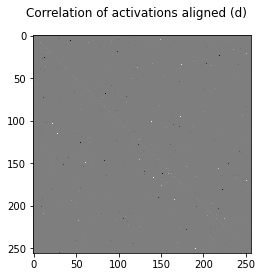

In [24]:
def greedy_match(correlations):
  
  pairs = []
  for i in range(len(correlations)):
    max_corr_idx = -1
    max_corr = -1000

    # ret.append(np.sort(correlations[i])[::-1])

    for j in range(len(correlations[i])):
      if (correlations[i][j] > max_corr) and (i != j):
        if (i == j):
          print("here")
        max_corr = correlations[i][j]
        max_corr_idx = j

    d = correlations[i][i] # get diagonal element
    correlations[i][i] = correlations[i][max_corr_idx] # swap with max correlated
    correlations[i][max_corr_idx] = d # put original diag element

    pairs.append((i, max_corr_idx, max_corr))

  return np.array(correlations), pairs

aligned_correlations, pairs = greedy_match(R1_xy)
fig = plt.figure()
fig.suptitle('Correlation of activations aligned (d)', fontsize=12)
showimagesc(aligned_correlations)

print(pairs)


In [26]:
def align_and_interpolate(audio_siren_joe1, audio_siren_joe2, model_input, ground_truth, pairs, layer_name="net.0.linear.weight"):

  ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
  # ratios = [0]

  for r in range(len(ratios)):
    r2 = ratios[r]
    r3 = 1-r2

    audio_siren4 = Siren(in_features=1, out_features=1, hidden_features=256, 
                                hidden_layers=5, first_omega_0=3000, outermost_linear=True)
    audio_siren4.cuda()

    # copy weights from 2nd model
    with torch.no_grad():
      for name1, param1 in audio_siren_joe2.named_parameters():
        for name2, param2 in audio_siren4.named_parameters():
          if (name1 == name2):
            param2.copy_(param1)

    # Audio after copying the weights should be same as the parent model's audio
    # aud = audio_siren4(model_input.cuda())[0].cpu().detach().squeeze().numpy()
    # display(Audio(aud, rate=rate))

    # align neurons
    with torch.no_grad():
      for name2, param2 in audio_siren4.named_parameters():
        if (name2 == layer_name):
          for idx1, idx2, corr in pairs:
            # align 2nd net according to index in pairs
            t = param2[idx1]
            param2[idx1] = param2[idx2]
            param2[idx2] = t

    # This aligned NN produces noisy output already
    # aud = audio_siren4(model_input.cuda())[0].cpu().detach().squeeze().numpy()
    # display(Audio(aud, rate=rate))

    # break

    with torch.no_grad():
      for name1, param1 in audio_siren_joe1.named_parameters():
        for name2, param2 in audio_siren4.named_parameters():
          if (name1 == name2 and name1 == layer_name):
            param2.copy_((r2*param1+r3*param2))
    
    print("audio_siren4 (r2=", r2, ", r3=", r3, ")")
    aud = audio_siren4(model_input.cuda())[0].cpu().detach().squeeze().numpy()
    display(Audio(aud, rate=rate))



# This file does not matter, since we are only using the timestamps which is same
# for all.
path = '/content/samples/joe2.wav'
audio_file = AudioFile(path)
dataloader = DataLoader(audio_file, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)
rate = audio_file.rate
 
model_input, ground_truth = next(iter(dataloader))

align_and_interpolate(audio_siren_joe1, audio_siren_joe2, model_input, ground_truth, pairs, layer_name="net.0.linear.weight")

audio_siren4 (r2= 0 , r3= 1 )


audio_siren4 (r2= 0.1 , r3= 0.9 )


audio_siren4 (r2= 0.2 , r3= 0.8 )


audio_siren4 (r2= 0.3 , r3= 0.7 )


audio_siren4 (r2= 0.4 , r3= 0.6 )


audio_siren4 (r2= 0.5 , r3= 0.5 )


audio_siren4 (r2= 0.6 , r3= 0.4 )


audio_siren4 (r2= 0.7 , r3= 0.30000000000000004 )


audio_siren4 (r2= 0.8 , r3= 0.19999999999999996 )


audio_siren4 (r2= 0.9 , r3= 0.09999999999999998 )


audio_siren4 (r2= 1 , r3= 0 )
